# **Topics in Data Science**
### ***Final Project - RNN Training***

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import Audio
import librosa
import seaborn as sns
import scipy

from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn import preprocessing, metrics
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import RidgeClassifier, LogisticRegression
from sklearn import svm
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, accuracy_score, classification_report
from sklearn.impute import SimpleImputer
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from imblearn.over_sampling import SMOTE
import joblib

import os
import sys

import numpy as np
import tensorflow as tf

from sklearn.model_selection import train_test_split

from keras.models import Sequential
from keras.layers import Dense, LSTM, Dropout
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau


In [2]:
# Load data
data_dir = './'
testcsv = pd.read_csv("./finalproject_test.csv")
traincsv = pd.read_csv("./finalproject_train.csv")
validcsv = pd.read_csv("./finalproject_validation.csv")

# Data preprocessing
X = traincsv.drop(columns=['label', 'file'])
y = traincsv['label']

# Impute missing values
imputer = SimpleImputer(strategy='mean')
X = imputer.fit_transform(X)

In [3]:
# Apply SMOTE to the training data
smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(X, y)

# Standardize features
scaler = StandardScaler()
X_resampled = scaler.fit_transform(X_resampled)

# Reshape data for LSTM
X_resampled = X_resampled.reshape((X_resampled.shape[0], 1, X_resampled.shape[1]))


In [4]:
#Uses recurrent neural networks to train model
def train_model(X_features, y):
    X_train, X_to_split, y_train, y_to_split = train_test_split(X_features, y, test_size=0.3, random_state=1)
    X_val, X_test, y_val, y_test = train_test_split(X_to_split, y_to_split, test_size=0.4, random_state=1)

    y_train_class = np.array(y_train) 
    y_val_class = np.array(y_val)

    model = Sequential()
    model.add(LSTM(128, return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2])))
    model.add(Dropout(0.2))
    model.add(LSTM(64))
    model.add(Dense(32, activation='relu'))
    model.add(Dropout(0.2))
    model.add(Dense(1, activation='sigmoid'))

    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

    early_stopping = EarlyStopping(monitor='val_loss', patience=4, verbose=1, mode='min', restore_best_weights=True)
    checkpoint = ModelCheckpoint('CustomModel.keras', monitor='val_loss', verbose=1, save_best_only=True, mode='min')
    rlrop = ReduceLROnPlateau(monitor='val_accuracy', factor=0.02, patience=100)

    history = model.fit(X_train, y_train_class, epochs=100, batch_size=32, validation_data=(X_val, y_val_class), callbacks=[rlrop, early_stopping, checkpoint])

    return model, history, X_test, y_test

# Call the train_model function with resampled data
model, history, X_test, y_test = train_model(X_resampled, y_resampled)



c:\Users\gavin\anaconda3\envs\voice\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/100
304/306 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.8042 - loss: 0.4491
Epoch 1: val_loss improved from inf to 0.10129, saving model to CustomModel.keras
306/306 ━━━━━━━━━━━━━━━━━━━━ 21s 28ms/step - accuracy: 0.8049 - loss: 0.4476 - val_accuracy: 0.9618 - val_loss: 0.1013 - learning_rate: 0.0010
Epoch 2/100
304/306 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.9717 - loss: 0.0867
Epoch 2: val_loss improved from 0.10129 to 0.07024, saving model to CustomModel.keras
306/306 ━━━━━━━━━━━━━━━━━━━━ 6s 18ms/step - accuracy: 0.9717 - loss: 0.0866 - val_accuracy: 0.9773 - val_loss: 0.0702 - learning_rate: 0.0010
Epoch 3/100
305/306 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.9816 - loss: 0.0530
Epoch 3: val_loss improved from 0.07024 to 0.04975, saving model to CustomModel.keras
306/306 ━━━━━━━━━━━━━━━━━━━━ 4s 14ms/step - accuracy: 0.9816 - loss: 0.0530 - val_accuracy: 0.9861 - val_loss: 0.0498 - learning_rate: 0.0010
Epoch 4/100
301/306 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step -

Test Loss: 0.032480545341968536
Test Accuracy: 0.9886566996574402
53/53 ━━━━━━━━━━━━━━━━━━━━ 2s 21ms/step


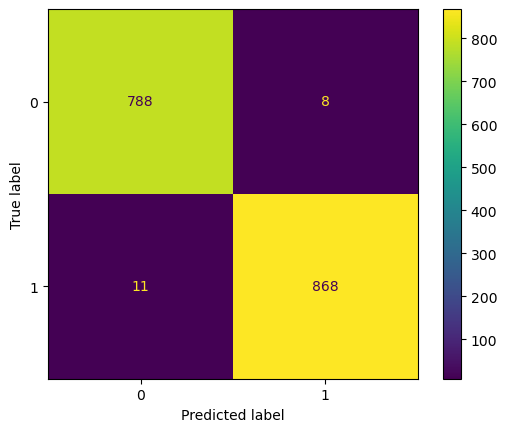

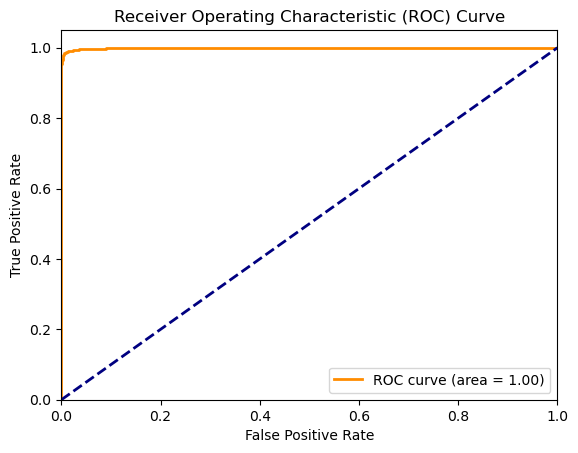

In [5]:
from sklearn.metrics import roc_curve, roc_auc_score, confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

def test_model(model, X_test, y_test):
    # Ensure y_test is a flat array
    y_test = y_test.values if isinstance(y_test, pd.Series) else y_test

    # Evaluate the model
    test_loss, test_accuracy = model.evaluate(X_test, y_test, verbose=0)
    
    print(f'Test Loss: {test_loss}')
    print(f'Test Accuracy: {test_accuracy}')

    # Predict Probabilities for the Test Set
    y_prob = model.predict(X_test)
    y_pred = (y_prob > 0.5).astype("int32")

    # Generate Confusion Matrix
    cm = confusion_matrix(y_test, y_pred)

    # Visualize Confusion Matrix
    disp = ConfusionMatrixDisplay(confusion_matrix=cm)
    disp.plot()
    plt.show()

    # Calculate ROC curve and ROC AUC score
    fpr, tpr, thresholds = roc_curve(y_test, y_prob)
    roc_auc = roc_auc_score(y_test, y_prob)

    # Plot ROC curve
    plt.figure()
    plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC) Curve')
    plt.legend(loc='lower right')
    plt.show()

# Call the test_model function
test_model(model, X_test, y_test)
